In [1]:
import numpy as np
import matplotlib.pyplot as plt
from OptimalHedging.Heston import HestonSimulator

# === (1) Set common parameters ===
S0 = 100
mu = 0.05
sigma = 0.2
v0 = 0.04
kappa = 2
theta = 0.04
sigma_v = 0.3
rho = 0.5
t0 = 0.0
T = 1.0
N = 252
M = 1000
K = 100
seed = 123

In [2]:
heston = HestonSimulator(S0=S0, mu=mu, sigma=sigma, v0=v0, kappa=kappa, theta=theta, sigma_v=sigma_v, rho=rho,
                          K=K, t0=t0, T=T, N=N, M=M, seed=seed)

S_heston, v_heston = heston.simulate_S()
H_heston, dH_dS, d2H_dSS, dH_dv, d2H_dvv, d2H_dSv, dH_dt = heston.simulate_H()
L_heston = heston.simulate_L()
p, q, r = heston.generate_adj(risk_type='ell')
h_opt = heston.update_control()
L_opt = heston.update_L()


[OK] Convergence achieved in 1 iterations (diff=0.00e+00)


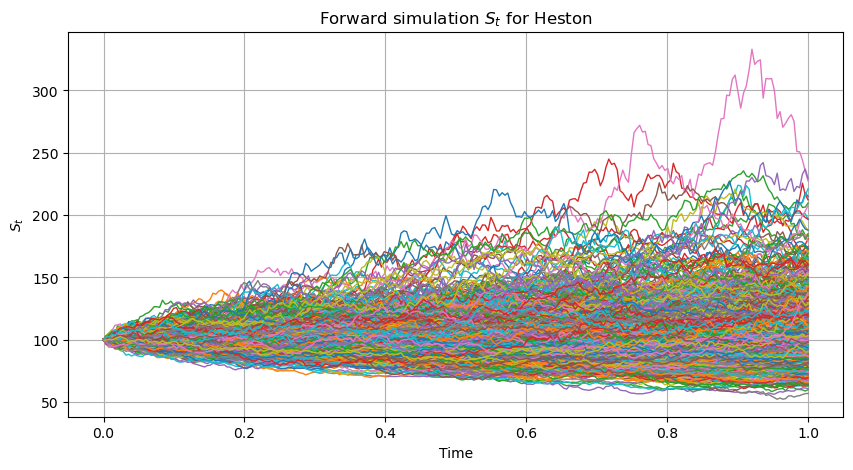

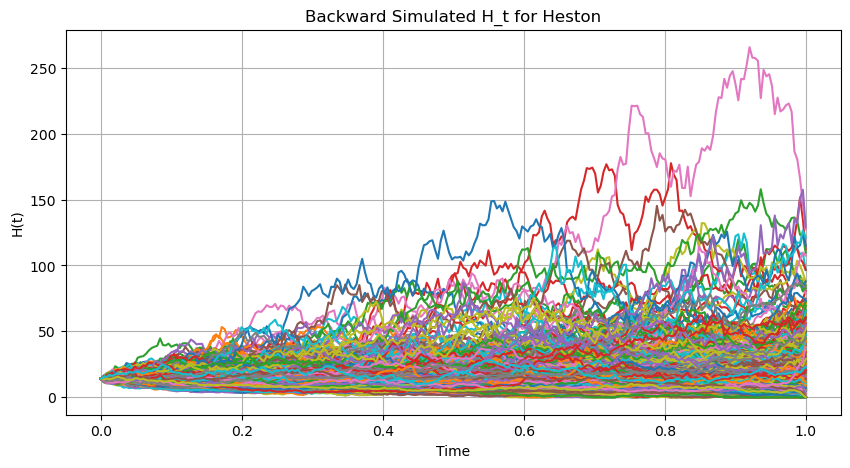

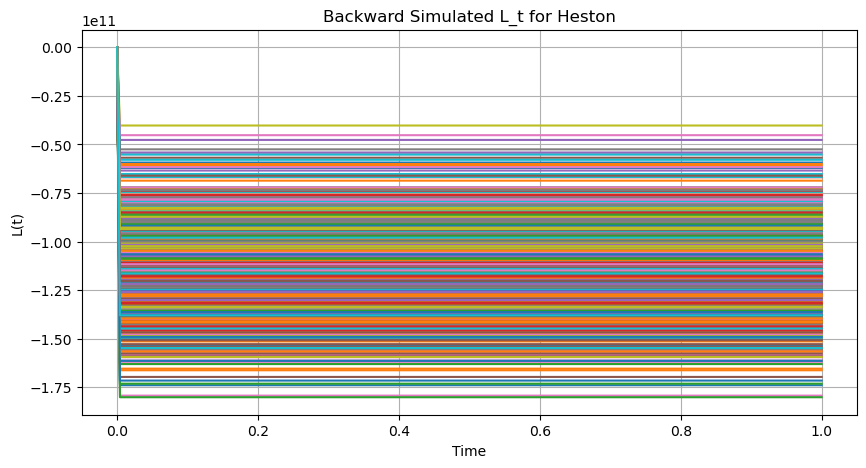

In [3]:
# === Grid de tempo ===
time_grid = np.linspace(t0, T, N)

# === Gráfico para S_t ===
plt.figure(figsize=(10, 5))
for i in range(M):   # M = número de simulações
    plt.plot(time_grid, S_heston[i, :], lw=1)  # <--- usa [i, :]
plt.title("Forward simulation $S_t$ for Heston")
plt.xlabel("Time")
plt.ylabel("$S_t$")
plt.grid(True)
plt.show()

# === Gráfico para H_t ===
plt.figure(figsize=(10, 5))
for i in range(M):
    plt.plot(time_grid, H_heston[i])
plt.title("Backward Simulated H_t for Heston")
plt.xlabel("Time")
plt.ylabel("H(t)")
plt.grid(True)
plt.show()

# === Gráfico para L_t ===
plt.figure(figsize=(10, 5))
for i in range(M):
    plt.plot(time_grid, L_opt[i])
plt.title("Backward Simulated L_t for Heston")
plt.xlabel("Time")
plt.ylabel("L(t)")
plt.grid(True)
plt.show()

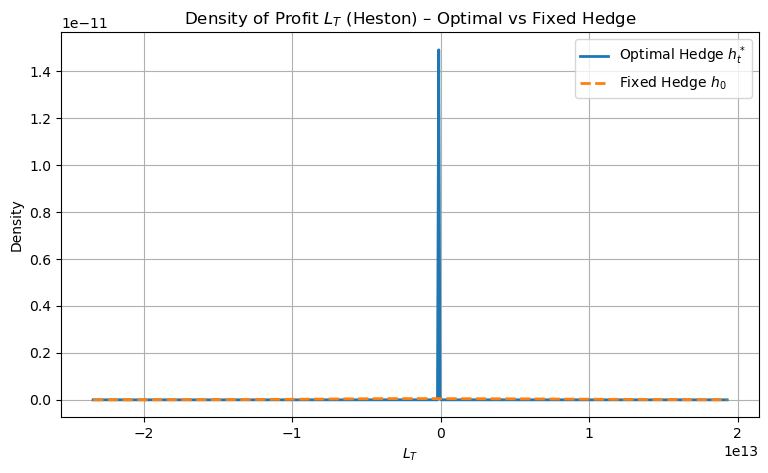

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# === Extraia os lucros finais ===
L_T_opt = heston.L_opt[:, -1]   # Lucro final com hedge ótimo
L_T_h0  = heston.L[:, -1]       # Lucro final com hedge inicial h0

# === Estime as densidades (KDE) ===
density_opt = gaussian_kde(L_T_opt)
density_h0  = gaussian_kde(L_T_h0)

# === Grid para plot ===
x_min = min(np.min(L_T_opt), np.min(L_T_h0))
x_max = max(np.max(L_T_opt), np.max(L_T_h0))
x_vals = np.linspace(x_min, x_max, 500)

# === Avalie as densidades ===
y_opt = density_opt(x_vals)
y_h0  = density_h0(x_vals)

# === Plote as duas curvas ===
plt.figure(figsize=(9, 5))
plt.plot(x_vals, y_opt, label="Optimal Hedge $h_t^*$", lw=2)
plt.plot(x_vals, y_h0, label="Fixed Hedge $h_0$", lw=2, linestyle="--")
plt.fill_between(x_vals, y_opt, alpha=0.2)
plt.fill_between(x_vals, y_h0, alpha=0.2)
plt.title("Density of Profit $L_T$ (Heston) – Optimal vs Fixed Hedge")
plt.xlabel("$L_T$")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


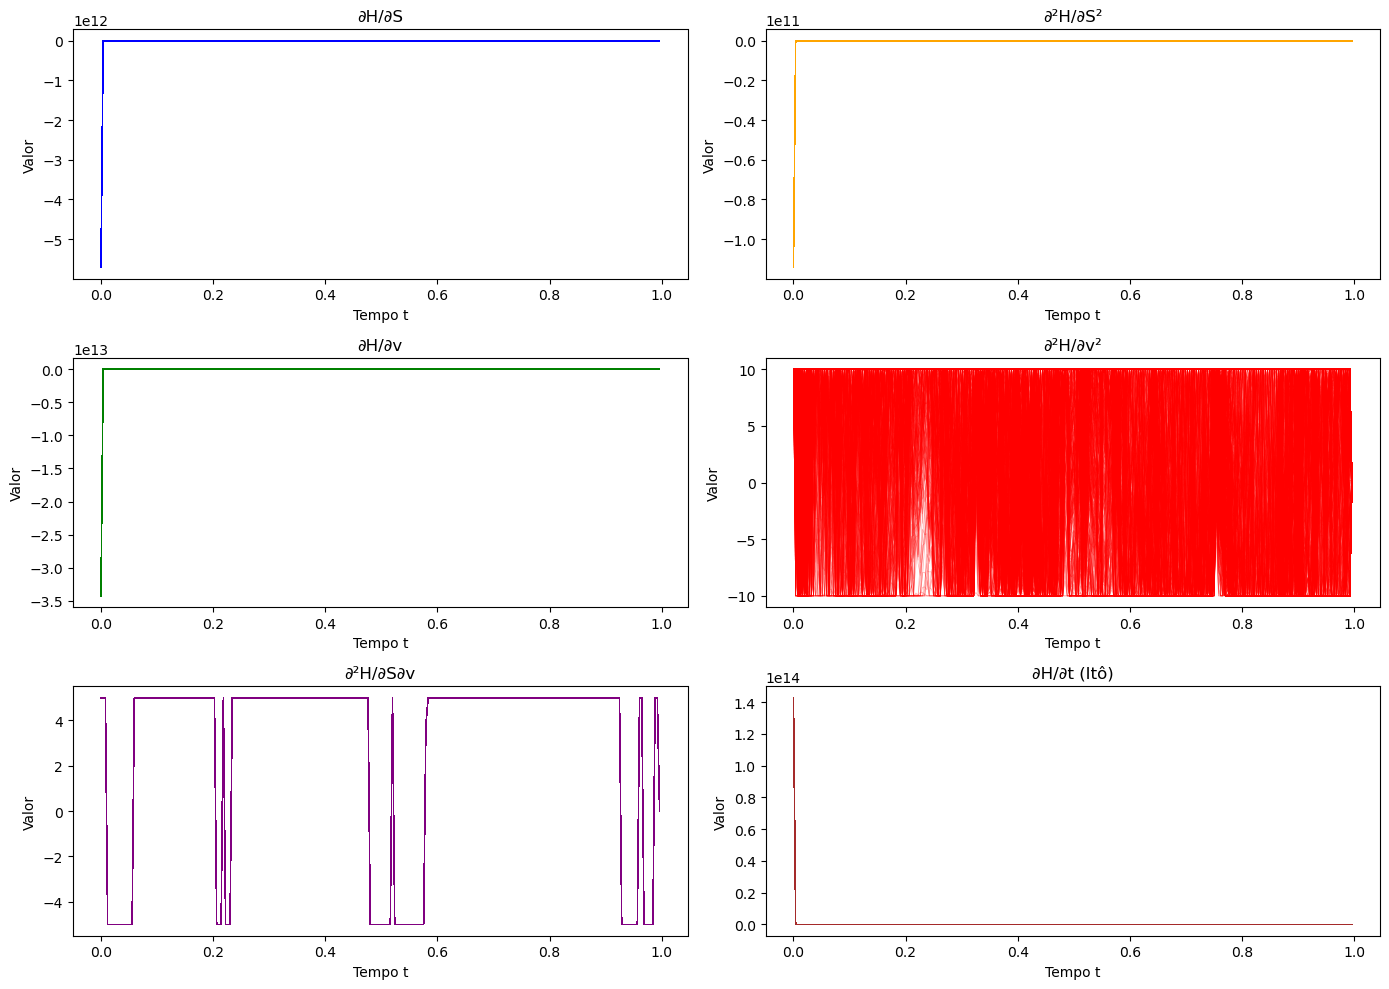

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Grade temporal
t_grid = np.linspace(0, heston.dt * (H_heston.shape[1] - 1), H_heston.shape[1])

# Lista de dados para plotagem
derivatives = [
    (dH_dS, "∂H/∂S", "blue"),
    (d2H_dSS, "∂²H/∂S²", "orange"),
    (dH_dv, "∂H/∂v", "green"),
    (d2H_dvv, "∂²H/∂v²", "red"),
    (d2H_dSv, "∂²H/∂S∂v", "purple"),
    (dH_dt, "∂H/∂t (Itô)", "brown")
]

# Criar figura com 3x2 subplots
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
axes = axes.flatten()

# Plotar TODAS as trajetórias
for ax, (data, title, color) in zip(axes, derivatives):
    for i in range(data.shape[0]):    # cada trajetória
        ax.plot(t_grid, data[i, :], color=color, alpha=0.3, linewidth=0.5)
    
    ax.set_title(title)
    ax.set_xlabel("Tempo t")
    ax.set_ylabel("Valor")

plt.tight_layout()
plt.show()



In [15]:
print(dH_dt)

[[ 1.42753597e+14  7.55632164e+00  9.07787490e+00 ... -1.07975643e+00
  -1.23145263e+00  0.00000000e+00]
 [ 1.42753597e+14  7.55632164e+00  9.07787490e+00 ... -1.07975643e+00
  -1.23145263e+00  0.00000000e+00]
 [ 1.42753597e+14  7.55632164e+00  9.07787490e+00 ... -1.07975643e+00
  -1.23145263e+00  0.00000000e+00]
 ...
 [ 1.42753597e+14  7.55632164e+00  9.07787490e+00 ... -1.07975643e+00
  -1.23145263e+00  0.00000000e+00]
 [ 1.42753597e+14  7.55632164e+00  9.07787490e+00 ... -1.07975643e+00
  -1.23145263e+00  0.00000000e+00]
 [ 1.42753597e+14  7.55632164e+00  9.07787490e+00 ... -1.07975643e+00
  -1.23145263e+00  0.00000000e+00]]
